In [1]:
from datetime import datetime
import pandas_datareader.data as dr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
import matplotlib.ticker as ticker #used for changing tick spacing
from finta import TA
from sklearn import preprocessing
import torch
import torch.nn as nn
import time

In [2]:
# stocklist = ['MSFT', 'AAPL', 'GOOG', 'FB', 'AMZN', 'V']
stocklist = 'V'

start = datetime(2015,6,9)
end = datetime(2021,6,9)

v = dr.DataReader(stocklist, 'yahoo', start, end)

In [3]:
v

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-09,68.089996,67.529999,67.669998,67.949997,4439700.0,65.270027
2015-06-10,69.669998,68.110001,68.220001,69.629997,6807800.0,66.883759
2015-06-11,70.019997,69.419998,69.699997,69.639999,5238700.0,66.893364
2015-06-12,69.739998,69.019997,69.430000,69.330002,4900700.0,66.595604
2015-06-15,68.989998,68.169998,68.720001,68.570000,5995100.0,65.865547
...,...,...,...,...,...,...
2021-06-03,230.389999,227.770004,229.000000,228.110001,6382400.0,228.110001
2021-06-04,230.699997,228.729996,229.350006,230.139999,5084900.0,230.139999
2021-06-07,234.679993,230.080002,232.850006,231.320007,5421300.0,231.320007


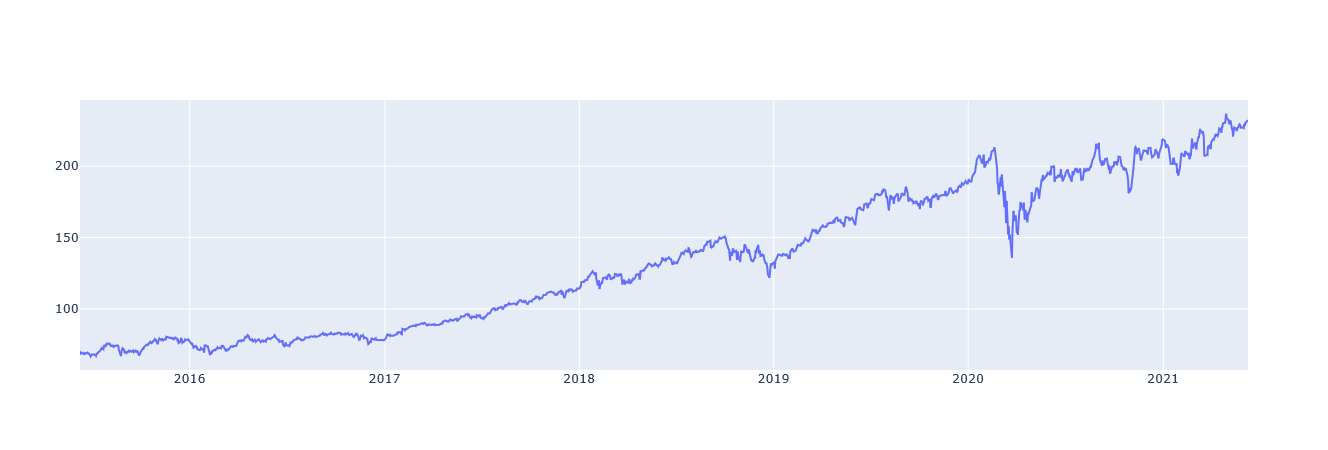

In [4]:
trace0 = go.Scatter(x=v.index, y=v.Close)
data = [trace0]
py.iplot(data)

In [6]:
fig_size = plt.rcParams["figure.figsize"] #loads current figure size
print('old size:',fig_size) #prints the size
fig_size[0] = 15 #sets the X size to 15
fig_size[1] = 8 #sets the Y size to 8
plt.rcParams["figure.figsize"] = fig_size #sets this numbers to the new size
fig_size = plt.rcParams["figure.figsize"] #loads the figure size for checking
print ('new size:',fig_size) #prints the figure size

old size: [15.0, 8.0]
new size: [15.0, 8.0]


Text(0.5, 0, 'Date')

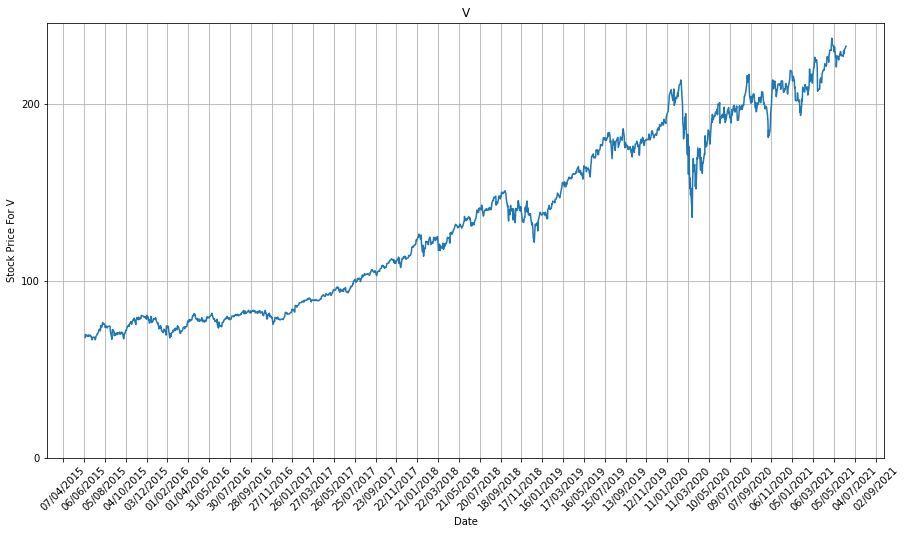

In [7]:
# x = [datetime.strptime(d,'%Y-%m-%d').date() for d in v.index.values] #convert date to something python understands
x = v.index
y = v.Close #plots which ever catagory you entered above

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y')) #display the date properly
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) #x axis tick every 60 days
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(x,y) #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title(stocklist) #prints the title on the top
plt.ylabel('Stock Price For '+ stocklist) #labels y axis
plt.xlabel('Date') #labels x axis


### Simple LSTM on raw close price

In [8]:
def train_test_split_preparation(new_df, train_split):
    #Preparation of train test set.
    train_indices = int(new_df.shape[0] * train_split)

    train_data = new_df[:train_indices]
    test_data = new_df[train_indices:]

    test_data = test_data.reset_index()
    test_data = test_data.drop(columns = ['index'])

    normaliser = preprocessing.MinMaxScaler()
    train_normalised_data = normaliser.fit_transform(train_data)

    test_normalised_data = normaliser.transform(test_data)

    X_train = np.array([train_normalised_data[:,0:][i : i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])

    y_train = np.array([train_normalised_data[:,0][i + history_points].copy() for i in range(len(train_normalised_data) - history_points)])
    y_train = np.expand_dims(y_train, -1)

    y_normaliser = preprocessing.MinMaxScaler()
    next_day_close_values = np.array([train_data['Adj Close'][i + history_points].copy() for i in range(len(train_data) - history_points)])
    next_day_close_values = np.expand_dims(next_day_close_values, -1)

    y_normaliser.fit(next_day_close_values)

     
    X_test = np.array([test_normalised_data[:,0:][i  : i + history_points].copy() for i in range(len(test_normalised_data) - history_points)])
    

    y_test = np.array([test_data['Adj Close'][i + history_points].copy() for i in range(len(test_data) - history_points)])
    
    y_test = np.expand_dims(y_test, -1)

    return X_train, y_train, X_test, y_test, y_normaliser

In [9]:
def add_technical_indicators(new_df):
    # Adding of technical indicators to data frame (Exponential moving average and Bollinger Band)
    edited_df = pd.DataFrame()

    edited_df['open'] = stock_df['Open']
    edited_df['high'] = stock_df['High']
    edited_df['low'] = stock_df['Low']
    edited_df['close'] = stock_df['Close']
    edited_df['volume'] = stock_df['Volume']
    edited_df.head()

    ema = TA.EMA(edited_df)
    bb = TA.BBANDS(edited_df)
    
    new_df['Exponential_moving_average'] = ema.copy()
    
    new_df = pd.concat([new_df, bb], axis = 1)

    for i in range(19):
        new_df['BB_MIDDLE'][i] = new_df.loc[i, 'Exponential_moving_average']
    
        if i != 0:
            higher = new_df.loc[i, 'BB_MIDDLE'] + 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            lower = new_df.loc[i, 'BB_MIDDLE'] - 2 * new_df['Adj Close'].rolling(i + 1).std()[i]
            new_df['BB_UPPER'][i] = higher
            new_df['BB_LOWER'][i] = lower
        else:
            new_df['BB_UPPER'][i] = new_df.loc[i, 'BB_MIDDLE']
            new_df['BB_LOWER'][i] = new_df.loc[i, 'BB_MIDDLE']
    return new_df

In [10]:
def on_balance_volume_creation(stock_df):
    # Adding of on balance volume to dataframe
    
    new_df = pd.DataFrame({})

    new_df = stock_df[['Adj Close']].copy()


    new_balance_volume = [0]
    tally = 0

    for i in range(1, len(new_df)):
        if (stock_df['Adj Close'][i] > stock_df['Adj Close'][i - 1]):
            tally += stock_df['Volume'][i]
        elif (stock_df['Adj Close'][i] < stock_df['Adj Close'][i - 1]):
            tally -= stock_df['Volume'][i]
        new_balance_volume.append(tally)

    new_df['On_Balance_Volume'] = new_balance_volume
    minimum = min(new_df['On_Balance_Volume'])

    new_df['On_Balance_Volume'] = new_df['On_Balance_Volume'] - minimum
    new_df['On_Balance_Volume'] = (new_df['On_Balance_Volume']+1).transform(np.log)

    return new_df

In [11]:
stock_df = v
stock_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-06-09,68.089996,67.529999,67.669998,67.949997,4439700.0,65.270027
2015-06-10,69.669998,68.110001,68.220001,69.629997,6807800.0,66.883759
2015-06-11,70.019997,69.419998,69.699997,69.639999,5238700.0,66.893364
2015-06-12,69.739998,69.019997,69.430000,69.330002,4900700.0,66.595604
2015-06-15,68.989998,68.169998,68.720001,68.570000,5995100.0,65.865547


In [12]:
stock_df = stock_df.reset_index(drop=True)

In [13]:
new_df2 = on_balance_volume_creation(stock_df)
new_df2

,Adj Close,On_Balance_Volume
0,65.270027,18.502174
1,66.883759,18.563034
2,66.893364,18.607468
3,66.595604,18.565961
4,65.865547,18.512725
...,...,...
1507,228.110001,20.713425
1508,230.139999,20.718547
1509,231.320007,20.723979
1510,232.050003,20.728138


In [14]:
new_df2 = new_df2.reset_index(drop=True)
new_df2

,Adj Close,On_Balance_Volume
0,65.270027,18.502174
1,66.883759,18.563034
2,66.893364,18.607468
3,66.595604,18.565961
4,65.865547,18.512725
...,...,...
1507,228.110001,20.713425
1508,230.139999,20.718547
1509,231.320007,20.723979
1510,232.050003,20.728138


In [15]:
new_df2 = add_technical_indicators(new_df2)
new_df2

,Adj Close,On_Balance_Volume,Exponential_moving_average,BB_UPPER,BB_MIDDLE,BB_LOWER
0,65.270027,18.502174,67.949997,67.949997,67.949997,67.949997
1,66.883759,18.563034,68.883330,71.165491,68.883330,66.601170
2,66.893364,18.607468,69.193441,71.062388,69.193441,67.324494
3,66.595604,18.565961,69.239701,70.785480,69.239701,67.693923
4,65.865547,18.512725,69.040480,70.465196,69.040480,67.615764
...,...,...,...,...,...,...
1507,228.110001,20.713425,227.709481,232.149601,226.999003,221.848404
1508,230.139999,20.718547,228.195585,231.905914,226.940002,221.974091
1509,231.320007,20.723979,228.820469,231.700364,226.900003,222.099642
1510,232.050003,20.728138,229.466376,232.500789,227.204003,221.907217


In [16]:
train_split = 0.7

history_points = 21
X_train, y_train, X_test, y_test, y_reverse_normaliser = train_test_split_preparation(new_df2, train_split)

In [17]:
# convering to torch

X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [18]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  torch.Size([1037, 21, 6])
y_train.shape =  torch.Size([1037, 1])
X_test.shape =  torch.Size([433, 21, 6])
y_test.shape =  torch.Size([433, 1])


We have our data ready.

Now for the model:

### LSTM

In [20]:
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [22]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.22335004806518555
Epoch  1 MSE:  0.1015828400850296
Epoch  2 MSE:  0.04570075497031212
Epoch  3 MSE:  0.098660908639431
Epoch  4 MSE:  0.05298615247011185
Epoch  5 MSE:  0.03862198069691658
Epoch  6 MSE:  0.042309269309043884
Epoch  7 MSE:  0.045097142457962036
Epoch  8 MSE:  0.04149681702256203
Epoch  9 MSE:  0.03164467215538025
Epoch  10 MSE:  0.018680838868021965
Epoch  11 MSE:  0.009924770332872868
Epoch  12 MSE:  0.013808158226311207
Epoch  13 MSE:  0.017166336998343468
Epoch  14 MSE:  0.008842390030622482
Epoch  15 MSE:  0.002171583939343691
Epoch  16 MSE:  0.0035629344638437033
Epoch  17 MSE:  0.008245956152677536
Epoch  18 MSE:  0.010092614218592644
Epoch  19 MSE:  0.007743611000478268
Epoch  20 MSE:  0.004147599916905165
Epoch  21 MSE:  0.0027371784672141075
Epoch  22 MSE:  0.004043615888804197
Epoch  23 MSE:  0.005452717654407024
Epoch  24 MSE:  0.00485654640942812
Epoch  25 MSE:  0.0031063267961144447
Epoch  26 MSE:  0.002068140311166644
Epoch  27 MSE:  0.00

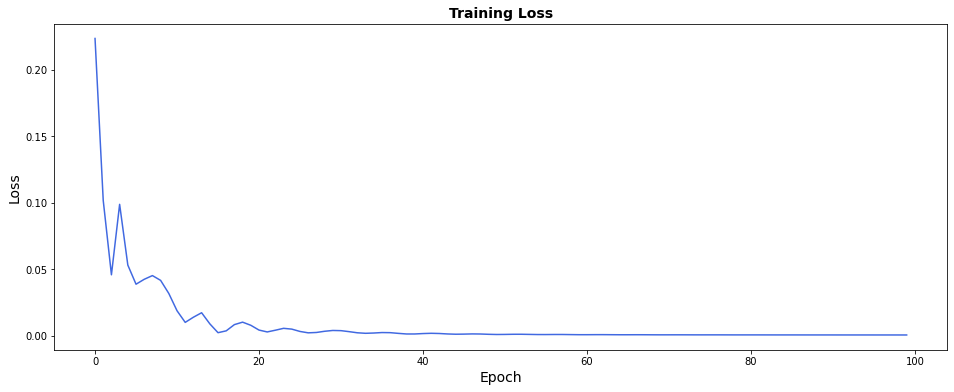

In [24]:
fig = plt.figure()
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [25]:
train_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_train_pred.detach().numpy()))
train_original = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_train.detach().numpy()))
print("train predict shape: ", train_predict.shape)
print("train original shape: ", train_original.shape)

train predict shape:  (1037, 1)
train original shape:  (1037, 1)


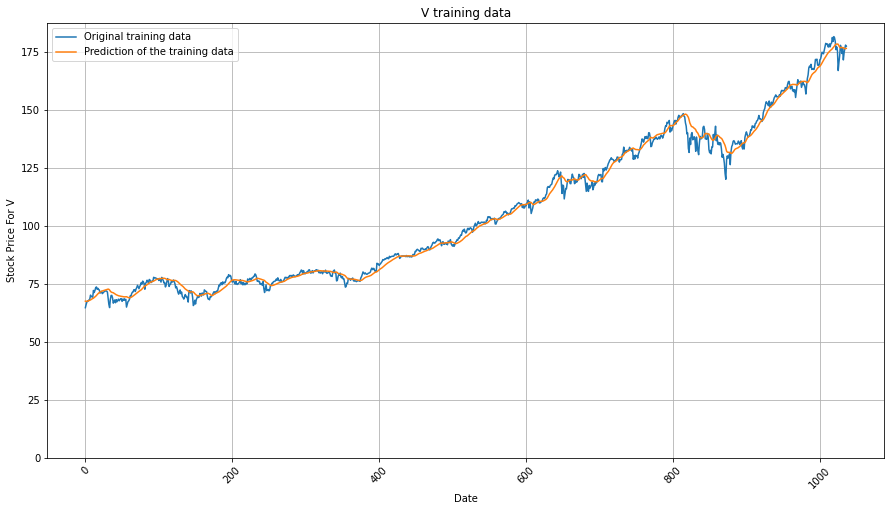

In [26]:
# x = [datetime.strptime(d,'%Y-%m-%d').date() for d in v.index.values] #convert date to something python understands
# x = v.index
# y = v.Close #plots which ever catagory you entered above

# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y')) #display the date properly
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60)) #x axis tick every 60 days
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100)) # sets y axis tick spacing to 100

plt.plot(train_original.index,train_original.values, label="Original training data") #plots the x and y
plt.plot(train_predict.index,train_predict.values, label="Prediction of the training data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title(stocklist + ' training data') #prints the title on the top
plt.ylabel('Stock Price For '+ stocklist) #labels y axis
plt.xlabel('Date') #labels x axis
plt.legend()


Computing the test prediction and plotting it:

In [27]:
y_pred = model(X_test)
test_predict = pd.DataFrame(y_reverse_normaliser.inverse_transform(y_pred.detach().numpy()))
test_original = pd.DataFrame((y_test.detach().numpy()))

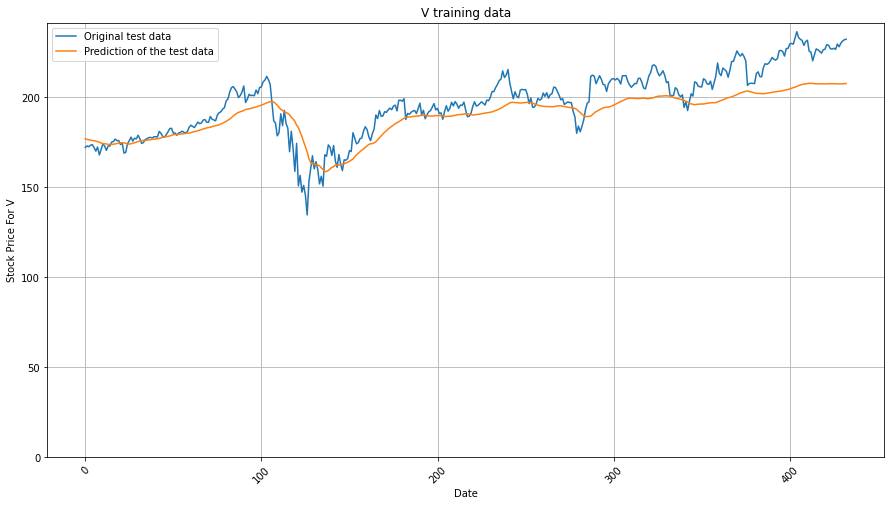

In [29]:
plt.plot(test_original.index, test_original.values, label="Original test data") #plots the x and y
plt.plot(test_predict.index,test_predict.values, label="Prediction of the test data") #plots the x and y
plt.grid(True) #turns on axis grid
plt.ylim(0) #sets the y axis min to zero
plt.xticks(rotation=45,fontsize = 10) #rotates the x axis ticks 90 degress and font size 10
plt.title(stocklist + ' training data') #prints the title on the top
plt.ylabel('Stock Price For '+ stocklist) #labels y axis
plt.xlabel('Date') #labels x axis
plt.legend()